Game defined as :

    *State: 
        - Grid size
        - Positions of living cells
    *Rules: eg
        - A cell survives if it has 2 or 3 neighbours -> dies if 1 or 0 neighbours 
        - Dies if it has more than 3 neighbours.
        - If a dead cell has 3 neighbours it becomes alive.
    *Stop test:
        - If current state = previous state 
        

In [63]:
%matplotlib inline
import matplotlib.animation as anim
import skimage.color
import skimage.io
import IPython.display
from io import BytesIO as bio
import PIL.Image
import numpy as np
from abc import ABC, abstractmethod
from copy import copy
import matplotlib.pyplot as plt
import matplotlib
import time
from collections import defaultdict
# matplotlib.use('GTK3Agg')
matplotlib.use('GTK3Agg')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  app.launch_new_instance()


In [64]:
class Game:
    def __init__(self, initial_state, rules,max_size):
        self.initial_state = initial_state
        self.rules = rules
        self.max_size = max_size
    def run_game(self, itera):
        state = self.initial_state
        previous_state = None
        tot = []
        i = 0
        while (not state.equals(previous_state) and i < itera):
            i += 1
            previous_state = state.copy()
            tot.append(previous_state.grid)
            state = state.apply_rules(self.rules,self.max_size)
        return tot

In [65]:
class State(ABC):
    @abstractmethod
    def copy(self):
        pass

    @abstractmethod
    def apply_rules(self, rules, max_size):
        pass

    @abstractmethod
    def equals(self, other):
        pass

    @abstractmethod
    def get_neighbours(self, elem, max_size):
        pass


class DenseNumpyState(State):
    def __init__(self, grid):
        self.grid = grid

    def copy(self):
        return DenseNumpyState(np.copy(self.grid))

    def equals(self, other):
        if other is None:
            return False
        return np.array_equal(self.grid, other.grid)

    def apply_rules(self, rules, max_size):
        self.grid = rules.apply_rules(self, max_size)
        return self

    def get_neighbours(self, elem, max_size):
        l = []
        if elem[0]-1 >= 0:
            l.append((elem[0]-1, elem[1]))
        if elem[0]-1 >= 0 and elem[1]-1 >= 0:
            l.append((elem[0]-1, elem[1]-1))
        if elem[0]-1 >= 0 and elem[1]+1 < max_size:
            l.append((elem[0]-1, elem[1]+1))
        if elem[1]-1 >= 0:
            l.append((elem[0], elem[1]-1))
        if elem[1]-1 >= 0 and elem[0]+1 < max_size:
            l.append((elem[0]+1, elem[1]-1))
        if elem[1]+1 < max_size:
            l.append((elem[0], elem[1]+1))
        if elem[0]+1 < max_size:
            l.append((elem[0]+1, elem[1]))
        if elem[1]+1 < max_size and elem[0]+1 < max_size:
            l.append((elem[0]+1, elem[1]+1))
        return l


class SparseSetState(State):
    def __init__(self, grid):
        self.grid = grid

    def copy(self):
        return SparseSetState(copy(self.grid))

    def get_neighbours(self, elem, max_size):
        l = []
        if elem[0]-1 >= 0:
            l.append((elem[0]-1, elem[1]))
        if elem[0]-1 >= 0 and elem[1]-1 >= 0:
            l.append((elem[0]-1, elem[1]-1))
        if elem[0]-1 >= 0 and elem[1]+1 < max_size:
            l.append((elem[0]-1, elem[1]+1))
        if elem[1]-1 >= 0:
            l.append((elem[0], elem[1]-1))
        if elem[1]-1 >= 0 and elem[0]+1 < max_size:
            l.append((elem[0]+1, elem[1]-1))
        if elem[1]+1 < max_size:
            l.append((elem[0], elem[1]+1))
        if elem[0]+1 < max_size:
            l.append((elem[0]+1, elem[1]))
        if elem[1]+1 < max_size and elem[0]+1 < max_size:
            l.append((elem[0]+1, elem[1]+1))
        return l

    def equals(self, other):
        if other is None:
            return False
        return self.grid == other.grid

    def apply_rules(self, rules, max_size):
        self.grid = rules.apply_rules(self, max_size)
        return self

In [66]:
class Rule(ABC):
    @abstractmethod
    def apply_rules(self, state):
        pass


class DenseNumpyRules(Rule):
    def apply_rules(self, state, max_size):
        copied_state = state.copy()
        grid = state.grid
        grid_ret = copied_state.grid
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                nei = state.get_neighbours((i,j),max_size)
                counter=0
                for n in nei:
                    if grid[n]== True:
                        counter+=1
                if (counter < 2 or counter > 3):
                    grid_ret[i][j] = False
                if (counter == 3):
                    grid_ret[i][j] = True
        return grid_ret


class SparseSetRules(Rule):
    def apply_rules(self, state, max_size):
        grid = state.grid
        counter = defaultdict(lambda: defaultdict(lambda: 0))
        for elem in grid:
            nei = state.get_neighbours(elem, max_size)
            for n in nei:
                if n not in counter:
                    counter[n] = 1
                else:
                    counter[n] += 1
        for c in counter:
            if (counter[c] < 2 or  counter[c] > 3) :
                grid.discard(c)
            if counter[c] == 3:
                grid.add(c)
        return grid

In [101]:
MAX_ITER = 100
MAX_SIZE = 80

init = np.zeros((MAX_SIZE, MAX_SIZE), dtype=bool)


# 1 stable light bulb
# init[40][40]=True
# init[40][41]=True
# init[40][42]=True

# Dies at 4th run
# init[40][41]=True
# init[40][42]=True
# init[40][43]=True
# init[40][44]=True

# 4 stable light bulbs
#init[40][40]=True
#init[40][41]=True
#init[40][42]=True
#init[40][43]=True
#init[40][44]=True

# 4 stable after thousands of iterations
#init[39][40] = True
#init[39][41] = True
#init[40][39] = True
#init[40][40] = True
#init[41][40] = True

# ruches
#init[40][40] = True
#init[41][39] = True
#init[42][39] = True
#init[43][40] = True
#init[41][41] = True
#init[40][41] = True
#init[42][41] = True


# 4 blocks 
init[40][40] = True
init[40][41] = True
init[39][41] = True
init[39][42] = True
init[38][42] = True
init[38][43] = True


#board = {(39, 40),(39, 41),(40, 39),(40, 40),(41, 40)}
#board={(40, 44),(40, 43),(40, 42),(40, 40),(40, 41)}
#board={(40, 40),(41, 39),(42, 39),(43, 40),(41, 41),(42, 41),(40,41)}
board={(40, 40),(40, 41),(39, 41),(39, 42),(38, 42),(38, 43)}

rules2 = SparseSetRules()
game = Game(SparseSetState(board), rules2,MAX_SIZE)

rules1 = DenseNumpyRules()
game1 = Game(DenseNumpyState(init), rules1,MAX_SIZE)




t = time.time()
rw1 = game1.run_game(MAX_ITER )
rw = game.run_game(MAX_ITER)

print(len(rw))
print(len(rw1))



time.time()-t



# rw.shape
# len(rw)

100
64


5.104554891586304

In [102]:
res1 = np.array(rw1)

In [109]:
res = np.zeros((len(rw),MAX_SIZE, MAX_SIZE), dtype=bool)
for l in range(0,len(rw)):
    for key in rw[l]:
        #print(key[0],key[1])
        res[l,key[0], key[1]] = True 

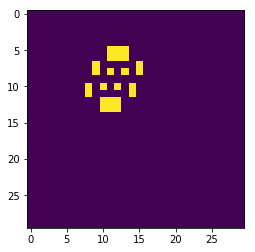

In [110]:
#or  l in range(len(rw1)):
 #   print((res1[l]== res[l]). all())
#print(res[8],res1[8])
#print(res[9],res1[9])


plt.imshow(res[8,30:60,30:60])


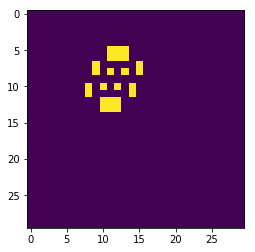

In [111]:
#or  l in range(len(rw1)):
 #   print((res1[l]== res[l]). all())
#print(res[8],res1[8])
#print(res[9],res1[9])


plt.imshow(res1[8,30:60,30:60])


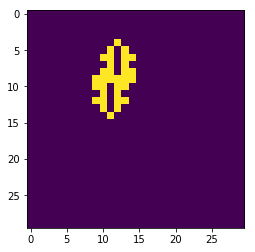

In [112]:
#or  l in range(len(rw1)):
 #   print((res1[l]== res[l]). all())
#print(res[8],res1[8])
#print(res[9],res1[9])


plt.imshow(res[9,30:60,30:60])


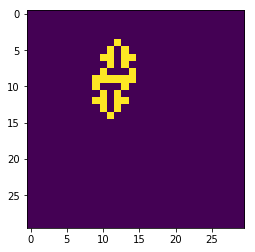

In [114]:
#or  l in range(len(rw1)):
 #   print((res1[l]== res[l]). all())
#print(res[8],res1[8])
#print(res[9],res1[9])


plt.imshow(res1[9,30:60,30:60])


In [49]:
def display_gif(array,file_name):
    array = array*255
    frames = []
    for frame in range(array.shape[0]):
        img = PIL.Image.fromarray(array[frame])
        img = img.resize((500, 500))
        frames.append(img)
    img.save(file_name, save_all=True, append_images=frames, loop=0,size=(500,500)
            )
    #IPython.display.Image(data=f.getvalue(), width="20%")

In [50]:
display_gif(res,"4.gif")
display_gif(res1,"41.gif")

![title](4.gif)

![title](all_frames.gif)

In [43]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))


def update(rw):
    ax.imshow(rw)


anim = FuncAnimation(fig, update, frames=rw[:200, :, :], interval=125)
anim.save('first-200-frames.gif', dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable. Trying to use pillow instead.


In [42]:
Image(filename="./last-200-frames.gif")

TypeError: 'module' object is not callable

![SegmentLocal](./last-50-frames.gif "segment")

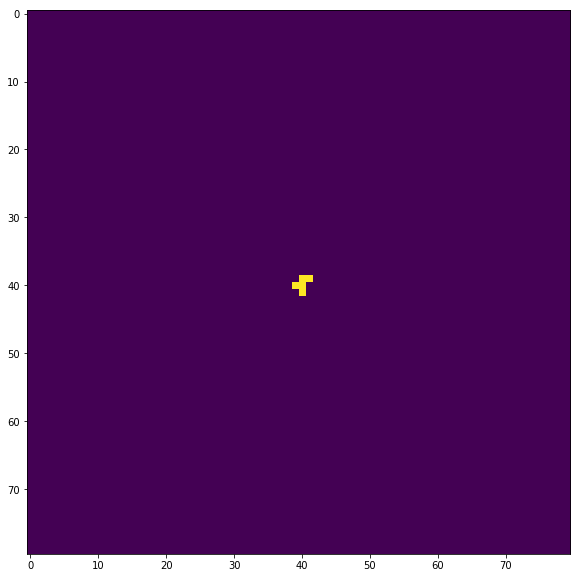

<Figure size 432x288 with 0 Axes>

In [108]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
myobj = ax.imshow(rw[0].grid, animated=True)

plt.show()
for i in range(1, 20):
    myobj.set_data(rw[i].grid)
    plt.draw()
    time.sleep(0.1)

plt.close(fig)

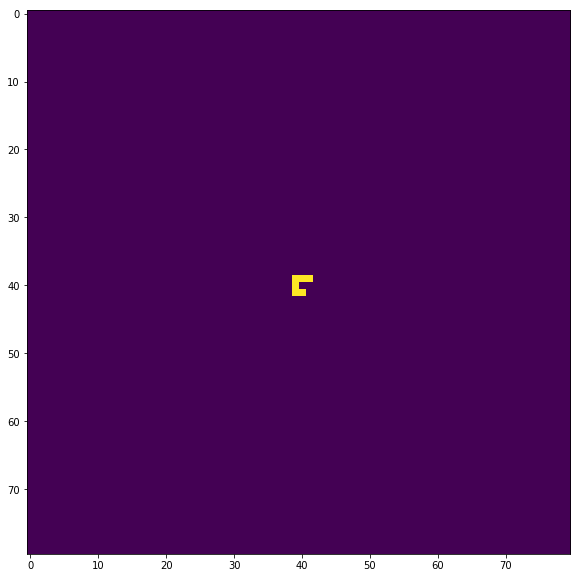

In [89]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)

myobj = ax.imshow(rw[1].grid)
plt.show()

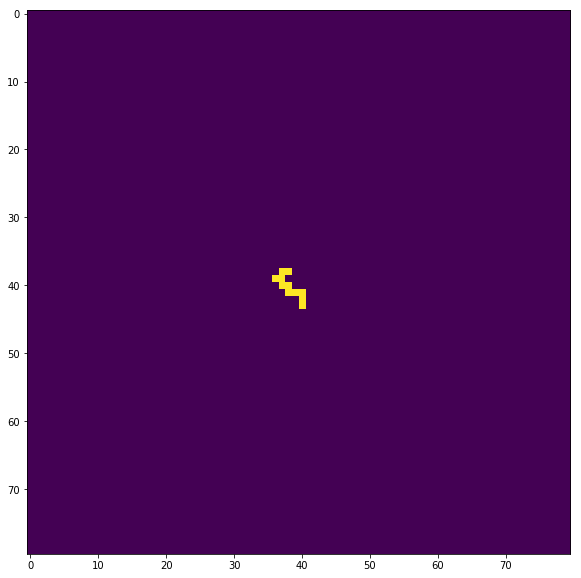

In [90]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)

myobj = ax.imshow(rw[10].grid)
plt.show()

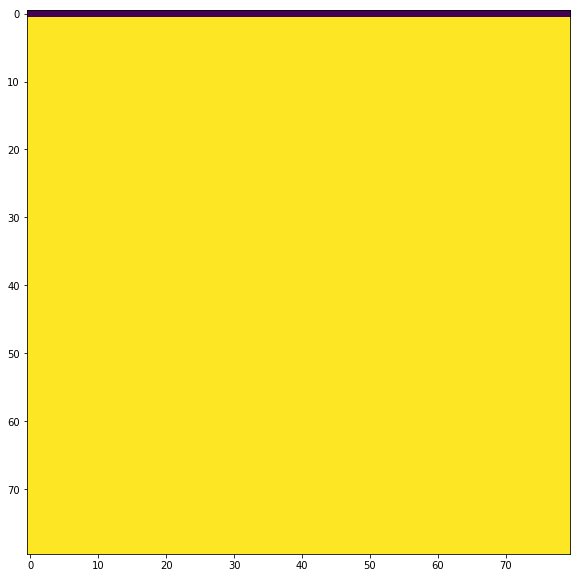

In [55]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)

myobj = ax.imshow(res[55])
plt.show()